In [2]:
import os
import sys
from tqdm import tqdm
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import KFold

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch
from tqdm import tqdm

In [3]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

train_file = np.load("./cse-251-b-2025/train.npz")
train_data = train_file['data']
print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)

test_file = np.load("./cse-251-b-2025/test_input.npz")
test_data = test_file['data']
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

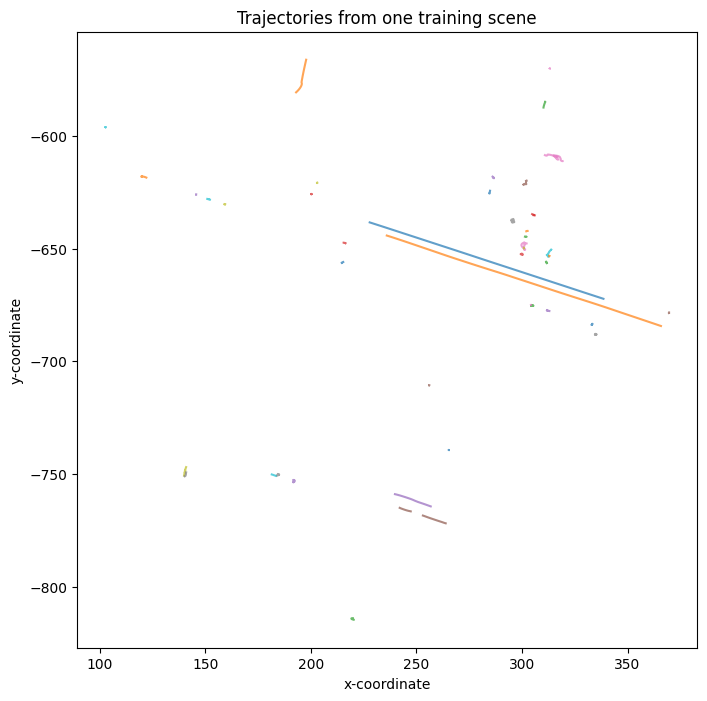

In [4]:
# Plot trajectories from one training scene (static plot)
data_matrix = train_data[0]

plt.figure(figsize=(8, 8))
for agent in range(data_matrix.shape[0]):
    xs = data_matrix[agent, :, 0]
    ys = data_matrix[agent, :, 1]
    # Remove zeros (padding)
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    plt.plot(xs, ys, alpha=0.7)
plt.title("Trajectories from one training scene")
plt.xlabel("x-coordinate")
plt.ylabel("y-coordinate")
plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

data_matrix = train_data[0]

# make_gif(data_matrix, 'index0')

# Constant velocity from test set
Untouched from original data loading notebook.

In [5]:
# Run this?
run_constant_velocity_model = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Our Work

In [6]:
# Base LSTM given to us in the milestone notebook
class BaseLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60 * 2, dropout=0):
        super(BaseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [7]:
# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):# In case you passed in a DataBatch
        if not isinstance(x_flat, torch.Tensor):
            x_flat = x_flat.x

        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)
        return self.decoder(combined) #(B, 120)

# Preparing data

`TrajectoryDataset*` are taken from the milestone notebook.

In [8]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R gives DeprecationWarning: future a torch.Tensor
                future = torch.from_numpy(np.dot(future.numpy(), R)) 
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin -> same DeprecationWarning
        future = torch.from_numpy(future.numpy() - origin)

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [9]:
# Taken from milestone notebook
# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Using CPU


In [14]:
# Calculate number of input features after flattening and number of output features
# Note: LSTM models take features in different dimensions
input_features = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each (15000 input features)
output_features = 60 * 2       # 60 future time steps, 2 dimensions (x, y) (120 output features)

# Hyperparameters
batch_size = 64
epochs = 25
starting_lr = 1e-2
gamma = 0.96
scale = 10.0

# Ensure this is pointing to the right model
OurModel = BaseLSTM(input_dim=6, hidden_dim=256, output_dim=output_features).to(device)
# OurModel = SceneContextModel(hidden_dim=864).to(device)

def train_model(full_training_data: np.ndarray, 
                batch_size: int =64, epochs: int =10, num_folds: int =5,
                early_stopping_patience: int=5, early_stopping_threshold: float=1e-3):
    global starting_lr, gamma, scale

    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=SEED)

    # Perform K-fold cross validation, then pick the best model
    best_model = None
    overall_best_val_loss = float("inf")

    # Resources used:
    # Project milestone notebook
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    for fold_i, (train_idx, val_idx) in enumerate(kfold.split(full_training_data)):
        print(f"\nFOLD {fold_i + 1}/{num_folds} ==================================")

        # Prepare data from this fold
        train_fold = full_training_data[train_idx]
        val_fold = full_training_data[val_idx]
        collate_func = None     # Optional for DataLoader, taken from milestone notebook
        if isinstance(OurModel, SceneContextModel):
            train_x = train_fold[..., :50, :]
            train_y = train_fold[:, 0, 50:, :2]
            X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
            y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

            val_x = val_fold[..., :50, :]
            val_y = val_fold[:, 0, 50:, :2]
            X_val_tensor = torch.FloatTensor(val_x).reshape((-1, input_features))
            y_val_tensor = torch.FloatTensor(val_y).reshape((-1, output_features))
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

            # Smaller LR, more patience
            starting_lr = 1e-2
            early_stopping_patience = 10
        else:
            # TrajectoryDataset expects numpy arrays
            collate_func = lambda x: Batch.from_data_list(x)
            train_dataset = TrajectoryDatasetTrain(train_fold, scale=scale, augment=True)
            val_dataset = TrajectoryDatasetTrain(val_fold, scale=scale, augment=False)
       
        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

        # Create the model, loss criterion, and optimizer (reset per fold, to find the best model)
        # DO NOT CHANGE CRITERION
        criterion = nn.MSELoss()
        model = OurModel
        optimizer = optim.AdamW(model.parameters(), lr=starting_lr, weight_decay=1e-2)
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=gamma)

        # How many epochs to allow for stagnant val losses (within a threshold)
        best_val_loss = float("inf")
        no_improvement = 0

        # Training loop: taken from milestone notebook
        for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                else: # DataBatch type
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
                optimizer.step()
                train_loss += loss.item()

            # Validation (fully taken from milestone notebook)
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch_x = None
                    batch_y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        batch_x, batch_y = batch
                    else: # DataBatch type
                        batch = batch.to(device)
                        batch_x = batch.x
                        batch_y = batch.y.view(batch.num_graphs, 60, 2)

                    pred = model(batch_x)
                    val_loss += criterion(pred, batch_y).item()

                    # show MAE and MSE with unnormalized data
                    y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        y = batch_y
                    else: # DataBatch type
                        y = batch.y.view(batch.num_graphs, 60, 2)
                        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                        y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    val_mae += nn.L1Loss()(pred, y).item()
                    val_mse += nn.MSELoss()(pred, y).item()

            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)
            
            scheduler.step()

            tqdm.write(f"Epoch {(epoch + 1):03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
            if val_loss < best_val_loss - early_stopping_threshold:
                best_val_loss = val_loss
                no_improvement = 0

                # Better than the overall seen so far?
                if best_val_loss < overall_best_val_loss:
                    best_model = model
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print("Early stop!")
                    break
    return best_model


# Train the model (tweak batch_size and epochs as needed)
trained_model = train_model(train_data, batch_size=batch_size, epochs=epochs)

# Define a function for prediction on the test set
# Mostly taken from milestone notebook
def predict(model, X_test):
    model.eval()

    pred_list = []
    with torch.no_grad():
        if isinstance(OurModel, SceneContextModel):
            X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
            pred = model(X_test_tensor).cpu().reshape((-1, 60, 2))
            pred_list.append(pred.numpy())
        else: # Using DataBatch type from a DataLoader
            collate_func = lambda x: Batch.from_data_list(x)
            test_dataset = TrajectoryDatasetTest(X_test, scale=scale)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

            for batch in test_loader:
                batch = batch.to(device)
                pred_norm = model(batch.x)
            
            # Reshape the prediction to (N, 60, 2)
                pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
                pred_list.append(pred.cpu().numpy())

    # Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
    pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
    pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
    output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
    output_df.index.name = 'index'
    return output_df

# Make predictions on the test set
model_predictions_df = predict(trained_model, test_data)

# Save output in the submission foldder, timestamped!
timestamp = datetime.now().strftime("%Y-%m-%d_%I-%M%p")

submission_path = os.path.join(submission_dir, f"submission-{timestamp}.csv")
model_predictions_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")


FOLD 1/5 ==================================


Epoch:   4%|▍         | 1/25 [00:11<04:29, 11.24s/epoch]

Epoch 001 | Learning rate 0.009600 | train normalized MSE   0.7408 | val normalized MSE   0.1907, | val MAE   2.3548 | val MSE  19.0675


Epoch:   8%|▊         | 2/25 [00:22<04:15, 11.12s/epoch]

Epoch 002 | Learning rate 0.009216 | train normalized MSE   0.1947 | val normalized MSE   0.1869, | val MAE   2.2650 | val MSE  18.6924


Epoch:  12%|█▏        | 3/25 [00:38<05:00, 13.66s/epoch]

Epoch 003 | Learning rate 0.008847 | train normalized MSE   0.1848 | val normalized MSE   0.1758, | val MAE   2.3501 | val MSE  17.5775


Epoch:  16%|█▌        | 4/25 [00:54<05:01, 14.38s/epoch]

Epoch 004 | Learning rate 0.008493 | train normalized MSE   0.1657 | val normalized MSE   0.1597, | val MAE   2.2617 | val MSE  15.9745


Epoch:  20%|██        | 5/25 [01:11<05:03, 15.18s/epoch]

Epoch 005 | Learning rate 0.008154 | train normalized MSE   0.1511 | val normalized MSE   0.1471, | val MAE   2.0130 | val MSE  14.7117


Epoch:  24%|██▍       | 6/25 [01:23<04:30, 14.22s/epoch]

Epoch 006 | Learning rate 0.007828 | train normalized MSE   0.1385 | val normalized MSE   0.1361, | val MAE   2.0576 | val MSE  13.6086


Epoch:  28%|██▊       | 7/25 [01:34<03:59, 13.31s/epoch]

Epoch 007 | Learning rate 0.007514 | train normalized MSE   0.1297 | val normalized MSE   0.1275, | val MAE   1.8753 | val MSE  12.7498


Epoch:  32%|███▏      | 8/25 [01:46<03:36, 12.72s/epoch]

Epoch 008 | Learning rate 0.007214 | train normalized MSE   0.1235 | val normalized MSE   0.1131, | val MAE   1.7374 | val MSE  11.3069


Epoch:  36%|███▌      | 9/25 [01:59<03:26, 12.91s/epoch]

Epoch 009 | Learning rate 0.006925 | train normalized MSE   0.1176 | val normalized MSE   0.1160, | val MAE   1.7814 | val MSE  11.5956


Epoch:  40%|████      | 10/25 [02:12<03:14, 12.93s/epoch]

Epoch 010 | Learning rate 0.006648 | train normalized MSE   0.1143 | val normalized MSE   0.1194, | val MAE   1.8093 | val MSE  11.9416


Epoch:  44%|████▍     | 11/25 [02:26<03:03, 13.09s/epoch]

Epoch 011 | Learning rate 0.006382 | train normalized MSE   0.1156 | val normalized MSE   0.1181, | val MAE   1.7507 | val MSE  11.8076


Epoch:  48%|████▊     | 12/25 [02:38<02:47, 12.90s/epoch]

Epoch 012 | Learning rate 0.006127 | train normalized MSE   0.1138 | val normalized MSE   0.1190, | val MAE   1.7530 | val MSE  11.9023


Epoch:  52%|█████▏    | 13/25 [02:51<02:34, 12.86s/epoch]

Epoch 013 | Learning rate 0.005882 | train normalized MSE   0.1087 | val normalized MSE   0.1105, | val MAE   1.6732 | val MSE  11.0514


Epoch:  56%|█████▌    | 14/25 [03:04<02:21, 12.84s/epoch]

Epoch 014 | Learning rate 0.005647 | train normalized MSE   0.1035 | val normalized MSE   0.1155, | val MAE   1.6756 | val MSE  11.5450


Epoch:  60%|██████    | 15/25 [03:16<02:07, 12.77s/epoch]

Epoch 015 | Learning rate 0.005421 | train normalized MSE   0.1044 | val normalized MSE   0.1065, | val MAE   1.6508 | val MSE  10.6490


Epoch:  64%|██████▍   | 16/25 [03:29<01:55, 12.83s/epoch]

Epoch 016 | Learning rate 0.005204 | train normalized MSE   0.1359 | val normalized MSE   0.1138, | val MAE   1.7823 | val MSE  11.3780


Epoch:  68%|██████▊   | 17/25 [03:40<01:38, 12.29s/epoch]

Epoch 017 | Learning rate 0.004996 | train normalized MSE   0.1085 | val normalized MSE   0.1068, | val MAE   1.6582 | val MSE  10.6835


Epoch:  72%|███████▏  | 18/25 [03:54<01:28, 12.69s/epoch]

Epoch 018 | Learning rate 0.004796 | train normalized MSE   0.1089 | val normalized MSE   0.1143, | val MAE   1.7086 | val MSE  11.4321


Epoch:  76%|███████▌  | 19/25 [04:11<01:23, 13.95s/epoch]

Epoch 019 | Learning rate 0.004604 | train normalized MSE   0.1040 | val normalized MSE   0.0989, | val MAE   1.5191 | val MSE   9.8940


Epoch:  80%|████████  | 20/25 [04:22<01:05, 13.14s/epoch]

Epoch 020 | Learning rate 0.004420 | train normalized MSE   0.1004 | val normalized MSE   0.1037, | val MAE   1.6150 | val MSE  10.3678


Epoch:  84%|████████▍ | 21/25 [04:33<00:49, 12.45s/epoch]

Epoch 021 | Learning rate 0.004243 | train normalized MSE   0.0975 | val normalized MSE   0.0993, | val MAE   1.5592 | val MSE   9.9266


Epoch:  88%|████████▊ | 22/25 [04:44<00:36, 12.14s/epoch]

Epoch 022 | Learning rate 0.004073 | train normalized MSE   0.0956 | val normalized MSE   0.0981, | val MAE   1.5352 | val MSE   9.8106


Epoch:  92%|█████████▏| 23/25 [04:55<00:23, 11.78s/epoch]

Epoch 023 | Learning rate 0.003911 | train normalized MSE   0.0950 | val normalized MSE   0.0977, | val MAE   1.5294 | val MSE   9.7713


Epoch:  96%|█████████▌| 24/25 [05:07<00:11, 11.78s/epoch]

Epoch 024 | Learning rate 0.003754 | train normalized MSE   0.0934 | val normalized MSE   0.0960, | val MAE   1.4886 | val MSE   9.5985


Epoch: 100%|██████████| 25/25 [05:18<00:00, 12.75s/epoch]


Epoch 025 | Learning rate 0.003604 | train normalized MSE   0.0938 | val normalized MSE   0.0967, | val MAE   1.5176 | val MSE   9.6745

FOLD 2/5 ==================================


Epoch:   4%|▍         | 1/25 [00:14<05:43, 14.32s/epoch]

Epoch 001 | Learning rate 0.009600 | train normalized MSE   0.1132 | val normalized MSE   0.1103, | val MAE   1.8102 | val MSE  11.0308


Epoch:   8%|▊         | 2/25 [00:30<05:57, 15.56s/epoch]

Epoch 002 | Learning rate 0.009216 | train normalized MSE   0.1077 | val normalized MSE   0.1035, | val MAE   1.6229 | val MSE  10.3536


Epoch:  12%|█▏        | 3/25 [00:45<05:36, 15.29s/epoch]

Epoch 003 | Learning rate 0.008847 | train normalized MSE   0.1052 | val normalized MSE   0.1080, | val MAE   1.6936 | val MSE  10.7971


Epoch:  16%|█▌        | 4/25 [00:59<05:08, 14.69s/epoch]

Epoch 004 | Learning rate 0.008493 | train normalized MSE   0.1046 | val normalized MSE   0.1060, | val MAE   1.6695 | val MSE  10.6033


Epoch:  20%|██        | 5/25 [01:12<04:38, 13.92s/epoch]

Epoch 005 | Learning rate 0.008154 | train normalized MSE   0.0994 | val normalized MSE   0.1074, | val MAE   1.7136 | val MSE  10.7435


Epoch:  24%|██▍       | 6/25 [01:23<04:11, 13.25s/epoch]

Epoch 006 | Learning rate 0.007828 | train normalized MSE   0.1040 | val normalized MSE   0.1068, | val MAE   1.6845 | val MSE  10.6765


Epoch:  28%|██▊       | 7/25 [01:35<03:50, 12.79s/epoch]

Epoch 007 | Learning rate 0.007514 | train normalized MSE   0.1026 | val normalized MSE   0.0979, | val MAE   1.5907 | val MSE   9.7914


Epoch:  32%|███▏      | 8/25 [01:53<04:04, 14.36s/epoch]

Epoch 008 | Learning rate 0.007214 | train normalized MSE   0.0962 | val normalized MSE   0.0964, | val MAE   1.5672 | val MSE   9.6437


Epoch:  36%|███▌      | 9/25 [02:10<04:03, 15.24s/epoch]

Epoch 009 | Learning rate 0.006925 | train normalized MSE   0.0944 | val normalized MSE   0.0962, | val MAE   1.5420 | val MSE   9.6175


Epoch:  40%|████      | 10/25 [02:28<03:59, 15.96s/epoch]

Epoch 010 | Learning rate 0.006648 | train normalized MSE   0.0952 | val normalized MSE   0.0954, | val MAE   1.5949 | val MSE   9.5351


Epoch:  44%|████▍     | 11/25 [02:45<03:46, 16.20s/epoch]

Epoch 011 | Learning rate 0.006382 | train normalized MSE   0.0935 | val normalized MSE   0.0946, | val MAE   1.5133 | val MSE   9.4564


Epoch:  48%|████▊     | 12/25 [03:02<03:35, 16.59s/epoch]

Epoch 012 | Learning rate 0.006127 | train normalized MSE   0.0922 | val normalized MSE   0.0955, | val MAE   1.5693 | val MSE   9.5519


Epoch:  52%|█████▏    | 13/25 [03:17<03:12, 16.05s/epoch]

Epoch 013 | Learning rate 0.005882 | train normalized MSE   0.0917 | val normalized MSE   0.0968, | val MAE   1.5191 | val MSE   9.6793


Epoch:  56%|█████▌    | 14/25 [03:30<02:45, 15.09s/epoch]

Epoch 014 | Learning rate 0.005647 | train normalized MSE   0.1821 | val normalized MSE   0.1149, | val MAE   1.8422 | val MSE  11.4893


Epoch:  56%|█████▌    | 14/25 [03:44<02:56, 16.07s/epoch]


Epoch 015 | Learning rate 0.005421 | train normalized MSE   0.1082 | val normalized MSE   0.1050, | val MAE   1.7097 | val MSE  10.5047
Early stop!

FOLD 3/5 ==================================


Epoch:   4%|▍         | 1/25 [00:13<05:16, 13.21s/epoch]

Epoch 001 | Learning rate 0.009600 | train normalized MSE   0.1078 | val normalized MSE   0.0984, | val MAE   1.6015 | val MSE   9.8418


Epoch:   8%|▊         | 2/25 [00:26<05:05, 13.29s/epoch]

Epoch 002 | Learning rate 0.009216 | train normalized MSE   0.1056 | val normalized MSE   0.1082, | val MAE   1.6804 | val MSE  10.8169


Epoch:  12%|█▏        | 3/25 [00:39<04:47, 13.06s/epoch]

Epoch 003 | Learning rate 0.008847 | train normalized MSE   0.1010 | val normalized MSE   0.0958, | val MAE   1.5883 | val MSE   9.5770


Epoch:  16%|█▌        | 4/25 [00:55<05:02, 14.43s/epoch]

Epoch 004 | Learning rate 0.008493 | train normalized MSE   0.0975 | val normalized MSE   0.0950, | val MAE   1.5023 | val MSE   9.5049


Epoch:  20%|██        | 5/25 [01:06<04:22, 13.12s/epoch]

Epoch 005 | Learning rate 0.008154 | train normalized MSE   0.0953 | val normalized MSE   0.0945, | val MAE   1.5539 | val MSE   9.4457


Epoch:  24%|██▍       | 6/25 [01:17<03:55, 12.37s/epoch]

Epoch 006 | Learning rate 0.007828 | train normalized MSE   0.0999 | val normalized MSE   0.0957, | val MAE   1.5235 | val MSE   9.5734


Epoch:  28%|██▊       | 7/25 [01:29<03:37, 12.09s/epoch]

Epoch 007 | Learning rate 0.007514 | train normalized MSE   0.0947 | val normalized MSE   0.0954, | val MAE   1.5778 | val MSE   9.5421


Epoch:  32%|███▏      | 8/25 [01:40<03:20, 11.77s/epoch]

Epoch 008 | Learning rate 0.007214 | train normalized MSE   0.0948 | val normalized MSE   0.0957, | val MAE   1.5742 | val MSE   9.5674


Epoch:  36%|███▌      | 9/25 [01:52<03:11, 11.95s/epoch]

Epoch 009 | Learning rate 0.006925 | train normalized MSE   0.0937 | val normalized MSE   0.0900, | val MAE   1.4533 | val MSE   8.9994


Epoch:  40%|████      | 10/25 [02:08<03:16, 13.09s/epoch]

Epoch 010 | Learning rate 0.006648 | train normalized MSE   0.0918 | val normalized MSE   0.0905, | val MAE   1.4825 | val MSE   9.0490


Epoch:  44%|████▍     | 11/25 [02:20<03:01, 12.93s/epoch]

Epoch 011 | Learning rate 0.006382 | train normalized MSE   0.0931 | val normalized MSE   0.0904, | val MAE   1.4733 | val MSE   9.0361


Epoch:  48%|████▊     | 12/25 [02:32<02:42, 12.52s/epoch]

Epoch 012 | Learning rate 0.006127 | train normalized MSE   0.0905 | val normalized MSE   0.0895, | val MAE   1.4611 | val MSE   8.9496


Epoch:  52%|█████▏    | 13/25 [02:44<02:27, 12.27s/epoch]

Epoch 013 | Learning rate 0.005882 | train normalized MSE   0.0907 | val normalized MSE   0.0888, | val MAE   1.4415 | val MSE   8.8774


Epoch:  56%|█████▌    | 14/25 [02:54<02:10, 11.88s/epoch]

Epoch 014 | Learning rate 0.005647 | train normalized MSE   0.0908 | val normalized MSE   0.0890, | val MAE   1.5090 | val MSE   8.9034


Epoch:  60%|██████    | 15/25 [03:06<01:56, 11.69s/epoch]

Epoch 015 | Learning rate 0.005421 | train normalized MSE   0.0891 | val normalized MSE   0.0927, | val MAE   1.5699 | val MSE   9.2660


Epoch:  64%|██████▍   | 16/25 [03:17<01:44, 11.66s/epoch]

Epoch 016 | Learning rate 0.005204 | train normalized MSE   0.0878 | val normalized MSE   0.0888, | val MAE   1.4475 | val MSE   8.8801


Epoch:  68%|██████▊   | 17/25 [03:29<01:32, 11.55s/epoch]

Epoch 017 | Learning rate 0.004996 | train normalized MSE   0.0883 | val normalized MSE   0.0893, | val MAE   1.5154 | val MSE   8.9323


Epoch:  68%|██████▊   | 17/25 [03:40<01:43, 12.95s/epoch]


Epoch 018 | Learning rate 0.004796 | train normalized MSE   0.0874 | val normalized MSE   0.0892, | val MAE   1.4528 | val MSE   8.9185
Early stop!

FOLD 4/5 ==================================


Epoch:   4%|▍         | 1/25 [00:10<04:14, 10.61s/epoch]

Epoch 001 | Learning rate 0.009600 | train normalized MSE   0.0982 | val normalized MSE   0.0841, | val MAE   1.4852 | val MSE   8.4104


Epoch:   8%|▊         | 2/25 [00:21<04:08, 10.81s/epoch]

Epoch 002 | Learning rate 0.009216 | train normalized MSE   0.0952 | val normalized MSE   0.0873, | val MAE   1.4940 | val MSE   8.7343


Epoch:  12%|█▏        | 3/25 [00:32<03:58, 10.84s/epoch]

Epoch 003 | Learning rate 0.008847 | train normalized MSE   0.0941 | val normalized MSE   0.0826, | val MAE   1.4069 | val MSE   8.2641


Epoch:  16%|█▌        | 4/25 [00:43<03:45, 10.75s/epoch]

Epoch 004 | Learning rate 0.008493 | train normalized MSE   0.0937 | val normalized MSE   0.0938, | val MAE   1.5416 | val MSE   9.3790


Epoch:  20%|██        | 5/25 [00:54<03:39, 10.99s/epoch]

Epoch 005 | Learning rate 0.008154 | train normalized MSE   0.0945 | val normalized MSE   0.0822, | val MAE   1.3856 | val MSE   8.2153


Epoch:  24%|██▍       | 6/25 [01:05<03:29, 11.03s/epoch]

Epoch 006 | Learning rate 0.007828 | train normalized MSE   0.0912 | val normalized MSE   0.0874, | val MAE   1.5367 | val MSE   8.7420


Epoch:  28%|██▊       | 7/25 [01:16<03:19, 11.09s/epoch]

Epoch 007 | Learning rate 0.007514 | train normalized MSE   0.1003 | val normalized MSE   0.0942, | val MAE   1.6383 | val MSE   9.4165


Epoch:  28%|██▊       | 7/25 [01:28<03:47, 12.62s/epoch]


Epoch 008 | Learning rate 0.007214 | train normalized MSE   0.0963 | val normalized MSE   0.0846, | val MAE   1.4081 | val MSE   8.4637
Early stop!

FOLD 5/5 ==================================


Epoch:   4%|▍         | 1/25 [00:12<05:02, 12.60s/epoch]

Epoch 001 | Learning rate 0.009600 | train normalized MSE   0.0966 | val normalized MSE   0.0971, | val MAE   1.6028 | val MSE   9.7076


Epoch:   8%|▊         | 2/25 [00:29<05:53, 15.37s/epoch]

Epoch 002 | Learning rate 0.009216 | train normalized MSE   0.0929 | val normalized MSE   0.1002, | val MAE   1.6194 | val MSE  10.0250


Epoch:  12%|█▏        | 3/25 [00:47<05:57, 16.26s/epoch]

Epoch 003 | Learning rate 0.008847 | train normalized MSE   0.0911 | val normalized MSE   0.0946, | val MAE   1.4750 | val MSE   9.4552


Epoch:  16%|█▌        | 4/25 [01:05<05:56, 16.97s/epoch]

Epoch 004 | Learning rate 0.008493 | train normalized MSE   0.0912 | val normalized MSE   0.0999, | val MAE   1.5941 | val MSE   9.9876


Epoch:  20%|██        | 5/25 [01:21<05:31, 16.56s/epoch]

Epoch 005 | Learning rate 0.008154 | train normalized MSE   0.0900 | val normalized MSE   0.0922, | val MAE   1.4544 | val MSE   9.2159


Epoch:  24%|██▍       | 6/25 [01:35<04:58, 15.73s/epoch]

Epoch 006 | Learning rate 0.007828 | train normalized MSE   0.0904 | val normalized MSE   0.0952, | val MAE   1.5162 | val MSE   9.5216


Epoch:  28%|██▊       | 7/25 [01:49<04:31, 15.11s/epoch]

Epoch 007 | Learning rate 0.007514 | train normalized MSE   0.0880 | val normalized MSE   0.0923, | val MAE   1.4602 | val MSE   9.2316


Epoch:  32%|███▏      | 8/25 [02:01<04:00, 14.14s/epoch]

Epoch 008 | Learning rate 0.007214 | train normalized MSE   0.0877 | val normalized MSE   0.0910, | val MAE   1.4303 | val MSE   9.1004


Epoch:  36%|███▌      | 9/25 [02:13<03:38, 13.63s/epoch]

Epoch 009 | Learning rate 0.006925 | train normalized MSE   0.0883 | val normalized MSE   0.0885, | val MAE   1.4257 | val MSE   8.8521


Epoch:  40%|████      | 10/25 [02:25<03:17, 13.18s/epoch]

Epoch 010 | Learning rate 0.006648 | train normalized MSE   0.0855 | val normalized MSE   0.0915, | val MAE   1.4713 | val MSE   9.1465


Epoch:  44%|████▍     | 11/25 [02:36<02:55, 12.51s/epoch]

Epoch 011 | Learning rate 0.006382 | train normalized MSE   0.0858 | val normalized MSE   0.0898, | val MAE   1.4198 | val MSE   8.9784


Epoch:  48%|████▊     | 12/25 [02:47<02:35, 11.98s/epoch]

Epoch 012 | Learning rate 0.006127 | train normalized MSE   0.0849 | val normalized MSE   0.0918, | val MAE   1.4674 | val MSE   9.1809


Epoch:  52%|█████▏    | 13/25 [02:58<02:20, 11.75s/epoch]

Epoch 013 | Learning rate 0.005882 | train normalized MSE   0.0876 | val normalized MSE   0.0902, | val MAE   1.4761 | val MSE   9.0184


Epoch:  52%|█████▏    | 13/25 [03:09<02:55, 14.59s/epoch]


Epoch 014 | Learning rate 0.005647 | train normalized MSE   0.0852 | val normalized MSE   0.0895, | val MAE   1.4648 | val MSE   8.9457
Early stop!
Submission saved locally as: './submission\submission-2025-05-08_05-46PM.csv'.


In [15]:
# Functions to save and load the model (should correspond to what was trained!)
def save_model(model, path="our_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(path="our_model.pth"):
    loaded_model = OurModel(input_features, output_features)
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model


# Example usage:
# save_model(model)
# model = load_model()